In [1]:
import AFQ.tractography as aft
import AFQ.registration as reg

Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/AFQ_data/templates 


In [2]:
import numpy as np

In [3]:
%load_ext xvfbmagic

In [4]:
import dipy.reconst.dti as dti
import dipy.core.gradients as dpg

In [5]:
import nibabel as nib

In [6]:
# Replace with a loop over subjects:
subject = '992774'

In [7]:
bvals = np.loadtxt('/home/ubuntu/data/%s/sess/dwi/dwi.bvals'%subject)
bvecs1 = np.loadtxt('/home/ubuntu/data/%s/sess/dwi/dwi.bvecs'%subject)
bvecs2 = np.copy(bvecs1)
bvecs2[:, 0] = bvecs2[:, 0] * -1

In [8]:
gtab = dpg.gradient_table(bvals, bvecs2, b0_threshold=10)

In [9]:
dwi_img = nib.load('/home/ubuntu/data/%s/sess/dwi/dwi.nii.gz'%subject)
dwi_data = dwi_img.get_data()

In [10]:
label_img = nib.load('/home/ubuntu/data/%s/sess/anat/aparc+aseg.nii.gz'%subject)

In [11]:
label_data_orig = label_img.get_data()

In [12]:
# Corpus callosum inc
cc_mask = ((label_data_orig==251) | 
           (label_data_orig==252) |
           (label_data_orig==253) |
           (label_data_orig==254) |
           (label_data_orig==255))

# Cerebral white matter in both hemispheres + corpus callosum
wm_mask = (label_data_orig==41) | (label_data_orig==2) | (cc_mask)

In [13]:
resamp_wm = np.round(reg.resample(wm_mask, dwi_data[..., 0], label_img.affine, dwi_img.affine)).astype(int)
resamp_cc = np.round(reg.resample(cc_mask, dwi_data[..., 0], label_img.affine, dwi_img.affine)).astype(int)

In [14]:
dti_model = dti.TensorModel(gtab)

In [15]:
dti_fit = dti_model.fit(dwi_data, mask=resamp_wm)

In [16]:
nib.save(nib.Nifti1Image(dti_fit.model_params, dwi_img.affine), 'dti_param.nii.gz')

In [17]:
streamlines = aft.track('dti_param.nii.gz', seed_mask=resamp_cc, 
                        stop_mask=wm_mask, stop_threshold=1, backend="threading", seeds=1)

In [18]:
%%xvfb
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors

# Prepare the display objects.
color = line_colors(streamlines)

streamlines_actor = fvtk.line(streamlines, line_colors(streamlines))

# Create the 3d display.
r = fvtk.ren()
fvtk.add(r, streamlines_actor)

fvtk.record(r, out_path='./figures/', n_frames=20, path_numbering=True,
            size=(800, 800))

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

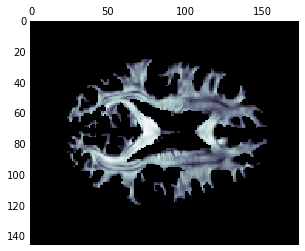

In [24]:
plt.matshow(dti_fit.fa[:, :, 70], cmap='bone')

In [26]:
from dipy.reconst.dti import color_fa
cfa = color_fa(dti_fit.fa, dti_fit.evecs)

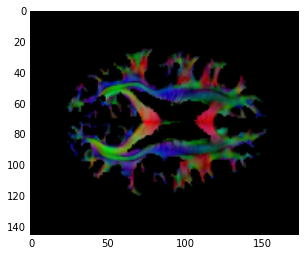

In [28]:
plt.imshow(cfa[:, :, 70])